# Agrawal & Veeraklae's problem: interactive demonstration

Hello and welcome. This is a Jupyter Notebook, a kind of document that can alternate between static content, like text and images, and executable cells of code.

This document ilustrates the Cart-pole swing-up test case of the paper: "Collocation Methods for Second Order Systems", submitted to RSS 2022.

In order to run the cells of code, you can select the cell and clic on the small "play" button in the bar above or press shift+enter. Alternatively, you can select the option "run -> run all cells" in order to run all the code in order. Beware that some cells can take several minutes!

All of the code used in this example is open-source and free to use.

[SymPy](https://www.sympy.org/en/index.html) is used for Symbolic formulation and manipulation of the problem.

[Numpy](https://numpy.org/) is used for numerical arrays and operations.

[CasADI](https://web.casadi.org/) is used for optimization.

[Chords](https://github.com/AunSiro/optibot) is the name of the package where we are compiling our code. We aim to produce a toolbox for Optimal Control Problems, focused on robotics, including a high level, readable and clean interface between the prior three packages.

## Package imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [197]:
from sympy import (symbols, simplify, Matrix, lambdify, exp)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody

In [3]:
from chords.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from chords.numpy import unpack

In [4]:
from functools import lru_cache
from copy import copy

In [5]:
from chords.util import (sch_to_lab, sch_to_color, sch_to_long_label, scheme_kwargs, oct_fig_size, set_fonts)
set_fonts()

In [6]:
#SymPy vector-like latex rendering inizialization:

init_vprinting()

## Symbolic Problem Modelling: 2nd Order Problem

The first step is to model our problem taking advantage of the high level object syntax of the mechanics module in SymPy

In [79]:
# Creating symbols and dynamic symbols

m1, m2, c1, c2, c3, k1, k2, k3 , u, t = symbols('m_{1:3} c_{1:4} k_{1:4} u t')
q1, q2 = dynamicsymbols('q_1 q_2')
m1, m2, c1, c2, c3, k1, k2, k3 , u, q1, q2

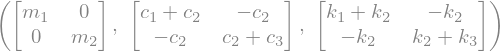

In [80]:
# Definition of the physics system

M = Matrix([
    [m1, 0],
    [0, m2]])
C = Matrix([
    [c1+c2, -c2],
    [-c2, c2+c3]])
K = Matrix([
    [k1+k2, -k2],
    [-k2, k2+k3]])
M, C, K

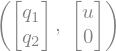

In [81]:
Q = Matrix([q1, q2])
U = Matrix([u, 0])
Q, U

In [82]:
Qd = Q.diff()
Qdd = Qd.diff()

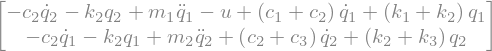

In [83]:
# Generating the dynamic equations

imp_dyn = M@Qdd + C@Qd + K@Q - U
imp_dyn

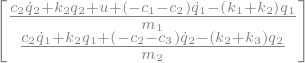

In [98]:
# Explicit Dynamics

exp_dyn = M.inv()@(-C@Qd - K@Q + U)
exp_dyn

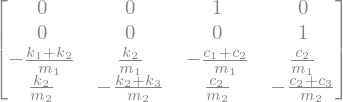

In [175]:
A_bar = Matrix.vstack(
    Matrix.hstack(Matrix.zeros(2), Matrix.eye(2)),
    - M.inv()@Matrix.hstack(K,C),
)
A_bar

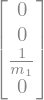

In [176]:
B_bar = Matrix.vstack(
    Matrix(
        [[0],
        [0]]
    ),
    M.inv()@ Matrix(
        [[1],
        [0]]
    )
)
B_bar

### Casadi optimization

We have generated the system equations symbolicaly. Now, we translate them to CasADi objects in order to perform the optimization.

In [192]:
#Numerical values of the paramenters

m1n, m2n = (1,1)
c1n, c2n, c3n, = (1,2,1)
k1n, k2n, k3n = (3,3,3)
params = [c1n, c2n, c3n, k1n, k2n, k3n, m1n, m2n]
params_sym = [c1, c2, c3, k1, k2, k3, m1, m2]

In [13]:
from chords.opti import Opti_Problem
import time
from functools import lru_cache

In [103]:
from chords.casadi import implicit_dynamic_x_to_casadi_function, rhs_to_casadi_function
from chords.numpy import RHS2numpy

In [15]:
x = dynamicsymbols('x_0:4')

In [16]:
x_d = [_i.diff() for _i in x]#symbols('\dot{x}_0:4')

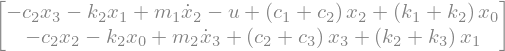

In [17]:
imp_dynx=imp_dyn.subs([
    [q1.diff(t,2), x_d[2]],
    [q2.diff(t,2), x_d[3]],
    [q1.diff(t), x[2]],
    [q2.diff(t), x[3]],
    [q1, x[0]],
    [q2, x[1]]
])
imp_dynx

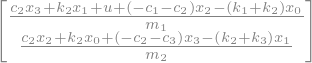

In [99]:
exp_dynx=exp_dyn.subs([
    [q1.diff(t,2), x_d[2]],
    [q2.diff(t,2), x_d[3]],
    [q1.diff(t), x[2]],
    [q2.diff(t), x[3]],
    [q1, x[0]],
    [q2, x[1]]
])
exp_dynx

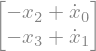

In [18]:
q_qdot = Matrix([x_d[0]-x[2],x_d[1]-x[3]])
q_qdot

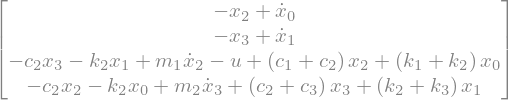

In [19]:
imp_dyn_full = Matrix.vstack(q_qdot, imp_dynx)
imp_dyn_full

In [20]:
imp_F_x_cas = implicit_dynamic_x_to_casadi_function(imp_dyn_full, x, [u,], verbose=True)
imp_F_x_cas

x vars expected: [x_0, x_1, x_2, x_3, x_0_dot, x_1_dot, x_2_dot, x_3_dot]
x vars found: [x_0, x_0_dot, x_1, x_1_dot, x_2, x_2_dot, x_3, x_3_dot]
u vars found: [u]
Lambda variables are separated from parameters
lambda vars found: []
a variables are not separated from parameters
Parameters found: [c_{1}, c_{2}, c_{3}, k_{1}, k_{2}, k_{3}, m_{1}, m_{2}]
Function Arguments:
	x: [x_0, x_1, x_2, x_3]
	x_dot: [x_0_dot, x_1_dot, x_2_dot, x_3_dot]
	u: [u]
	lambdas: []
	params: [c_{1}, c_{2}, c_{3}, k_{1}, k_{2}, k_{3}, m_{1}, m_{2}]



Function(M:(x[4],x_dot[4],u,lambdas[0],params[8])->(residue[1x4]) MXFunction)

In [105]:
exp_F_x_cas = rhs_to_casadi_function(exp_dyn, [q1, q2], [u,], verbose=True)

x vars expected: [q_1, q_2, v_1, v_2]
x vars found: [q_1, q_2, v_1, v_2]
u vars found: [u]
Lambda variables are not separated from parameters
a variables are not separated from parameters
Parameters found: [c_{1}, c_{2}, c_{3}, k_{1}, k_{2}, k_{3}, m_{1}, m_{2}]
Function Arguments:
	x: [q_1, q_2, v_1, v_2]
	u: [u]
	params: [c_{1}, c_{2}, c_{3}, k_{1}, k_{2}, k_{3}, m_{1}, m_{2}]



In [106]:
F_num = RHS2numpy(exp_dyn, [q1, q2], [u,], verbose=True)

x vars expected: [q_1, q_2, v_1, v_2]
x vars found: [q_1, q_2, v_1, v_2]
u vars found: [u]
Lambda variables are not separated from parameters
a variables are not separated from parameters
Parameters found: [c_{1}, c_{2}, c_{3}, k_{1}, k_{2}, k_{3}, m_{1}, m_{2}]
Function Arguments:
	x: [q_1, q_2, v_1, v_2]
	u: [u]
	params: [c_{1}, c_{2}, c_{3}, k_{1}, k_{2}, k_{3}, m_{1}, m_{2}]



## Symbolic Problem Modelling: 4th Order Problem

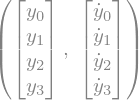

In [376]:
y = dynamicsymbols('y_0:4')
y_d = [_i.diff() for _i in y]
Y = Matrix(y)
Y_d = Matrix(y_d)
Y, Y_d

In [377]:
y4 = -6 * y[3] - 17 * y[2] - 24 * y[1] -27 * y[0] + u
y4

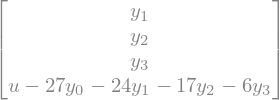

In [380]:
exp_dyn_4th = Matrix.vstack(Y[1:,:], Matrix([y4]))
exp_dyn_4th

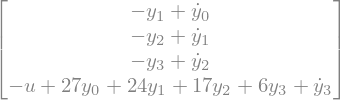

In [382]:
imp_dyn_4th =  Y_d - exp_dyn_4th
imp_dyn_4th

In [384]:
imp_F_x_cas_4th = implicit_dynamic_x_to_casadi_function(imp_dyn_4th, y, [u,], verbose=True)
imp_F_x_cas_4th

x vars expected: [y_0, y_1, y_2, y_3, y_0_dot, y_1_dot, y_2_dot, y_3_dot]
x vars found: [y_0, y_0_dot, y_1, y_1_dot, y_2, y_2_dot, y_3, y_3_dot]
u vars found: [u]
Lambda variables are separated from parameters
lambda vars found: []
a variables are not separated from parameters
Parameters found: []
Function Arguments:
	x: [y_0, y_1, y_2, y_3]
	x_dot: [y_0_dot, y_1_dot, y_2_dot, y_3_dot]
	u: [u]
	lambdas: []
	params: []



Function(M:(x[4],x_dot[4],u,lambdas[0],params[0])->(residue[1x4]) MXFunction)

In [389]:
T = np.array([
    [0,  1, -3,   7],
    [0,  0,  2,  -9],
    [1, -3,  7, -15],
    [0,  2, -9,  20]
])
D = np.array([
    [24, 17, 6, 1],
    [17,  6, 1, 0],
    [ 6,  1, 0, 0],
    [ 1,  0, 0, 0]
])
TD = T@D
TD_inv = np.linalg.inv(TD)
T, D, TD, TD_inv

(array([[  0,   1,  -3,   7],
        [  0,   0,   2,  -9],
        [  1,  -3,   7, -15],
        [  0,   2,  -9,  20]]),
 array([[24, 17,  6,  1],
        [17,  6,  1,  0],
        [ 6,  1,  0,  0],
        [ 1,  0,  0,  0]]),
 array([[6, 3, 1, 0],
        [3, 2, 0, 0],
        [0, 6, 3, 1],
        [0, 3, 2, 0]]),
 array([[ 0.26666667, -0.2       ,  0.        , -0.13333333],
        [-0.4       ,  0.8       ,  0.        ,  0.2       ],
        [ 0.6       , -1.2       , -0.        ,  0.2       ],
        [ 0.6       , -1.2       ,  1.        , -1.8       ]]))

In [463]:
def Y_to_X(Y):
    return (TD@Y.T).T

def X_to_Y(X):
    return (TD_inv@X.T).T

def interp_dict_Y_to_X(interpolations):
    n_q = 2
    
    Y = interpolations['x']
    Y_d = interpolations['x_d']
    Y_d_d = interpolations['x_d_d']
    U = interpolations['u']
    
    X = Y_to_X(Y)
    X_d = Y_to_X(Y_d)
    X_d_d = Y_to_X(Y_d_d)
    
    Q = X[:, :n_q]
    V = X[:, n_q:]
    Q_d = X_d[:, :n_q]
    A = X_d[:, n_q:]
    Q_d_d = X_d_d[:, :n_q]

    new_interp = {
        'x': X,
        'x_d': X_d,
        'x_d_d': X_d_d,
        'q': Q,
        'q_d': Q_d,
        'q_d_d': Q_d_d,
        'v': V,
        'a': A,
        'u': U
    }
    return new_interp

In [395]:
Y_to_X(np.array([-4, 16, -14, -44]))

array([10, 20, 10, 20])

In [394]:
X_to_Y(np.array([10,20,10,20]))

array([ -4.,  16., -14., -44.])

## Symbolic Problem Modelling: Exact Solution

In [209]:
from scipy.linalg import expm

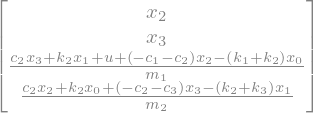

In [182]:
exp_dyn_full = Matrix.vstack(Matrix([x[2], x[3]]), exp_dynx)
exp_dyn_full

In [183]:
X = Matrix(x)
u_mat = Matrix([[u]])
simplify(A_bar @ X + B_bar @ u_mat - exp_dyn_full)

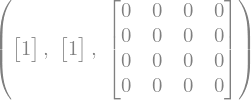

In [185]:
R = Matrix.eye(1)
Q = Matrix.zeros(4)
R,R.inv(),Q

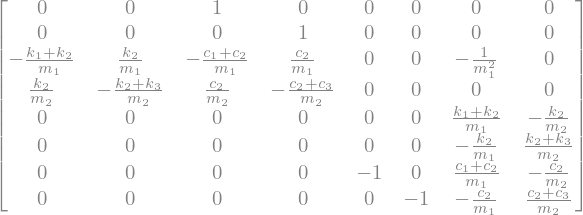

In [190]:
A_hat_sym = Matrix.vstack(
    Matrix.hstack(A_bar, -B_bar @ R.inv() @ B_bar.T),
    Matrix.hstack(-Q, -A_bar.T)
)
A_hat_sym

In [196]:
A_hat_numpy = lambdify(params_sym, A_hat_sym)
A_hat = A_hat_numpy(*params)
A_hat

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [-6.,  3., -3.,  2.,  0.,  0., -1.,  0.],
       [ 3., -6.,  2., -3.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  6., -3.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -3.,  6.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  3., -2.],
       [ 0.,  0.,  0.,  0.,  0., -1., -2.,  3.]])

In [203]:
A_hat_int = np.array(A_hat, dtype = int)
A_hat_int

array([[ 0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0],
       [-6,  3, -3,  2,  0,  0, -1,  0],
       [ 3, -6,  2, -3,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  6, -3],
       [ 0,  0,  0,  0,  0,  0, -3,  6],
       [ 0,  0,  0,  0, -1,  0,  3, -2],
       [ 0,  0,  0,  0,  0, -1, -2,  3]])

In [279]:
RiBT_sym = R.inv()@B_bar.T
RiBT_sym

In [280]:
RiBT_numpy = lambdify(params_sym, RiBT_sym)
RiBT = RiBT_numpy(*params)
RiBT

array([[0., 0., 1., 0.]])

In [228]:
def A_hat_exp(t):
    return expm(t * A_hat)

In [229]:
_e_tf = A_hat_exp(2)
S11 = _e_tf[:4, :4]
S12 = _e_tf[:4, 4:]
S21 = _e_tf[4:, :4]
S22 = _e_tf[4:, 4:]

In [235]:
xf = np.array([
    [0],
    [0],
    [0],
    [0]
], dtype = 'float64')
x0 = np.array([
    [10],
    [20],
    [10],
    [20]
], dtype = 'float64')
lambda0 = np.linalg.inv(S12) @ (xf - S11@x0)
lambda0

array([[356.48478391],
       [434.84682591],
       [190.22382887],
       [198.89091676]])

In [289]:
def exact_solution(t):
    _e_tf = A_hat_exp(t)
    S11 = _e_tf[:4, :4]
    S12 = _e_tf[:4, 4:]
    S21 = _e_tf[4:, :4]
    S22 = _e_tf[4:, 4:]
    return (S11 @ x0 + S12 @ lambda0).T

def u_exact_solution(t):
    _e_tf = A_hat_exp(t)
    S11 = _e_tf[:4, :4]
    S12 = _e_tf[:4, 4:]
    S21 = _e_tf[4:, :4]
    S22 = _e_tf[4:, 4:]
    lambda_t = S21 @ x0 + S22 @ lambda0
    return (-RiBT@lambda_t)[0,0]

In [290]:
exact_solution(2)

array([[-2.04281037e-13, -7.10542736e-15, -3.47721851e-13,
        -1.84741111e-13]])

In [291]:
u_exact_solution(2)

In [292]:
def exact_solution_array(t_arr):
    n_t = len(t_arr)
    sol = np.zeros([n_t, 4], dtype = 'float64')
    for ii in range(n_t):
        sol[ii,:] = exact_solution(t_arr[ii])
    return sol

def u_exact_solution_array(t_arr):
    n_t = len(t_arr)
    sol = np.zeros([n_t, 1], dtype = 'float64')
    for ii in range(n_t):
        sol[ii,:] = u_exact_solution(t_arr[ii])
    return sol

@lru_cache(maxsize=None)
def exact_solution_equispaced(n):
    t_end = 2
    t_interp_ex = np.linspace(0,t_end,n)
    return exact_solution_array(t_interp_ex)

In [293]:
exact_solution_array([0,1,2])

array([[ 1.00000000e+01,  2.00000000e+01,  1.00000000e+01,
         2.00000000e+01],
       [-4.54054114e+00, -4.18489209e-01,  6.50537071e+00,
        -2.18647363e+01],
       [-2.04281037e-13, -7.10542736e-15, -3.47721851e-13,
        -1.84741111e-13]])

In [294]:
u_exact_solution_array([0,1,2])

array([[-190.22382887],
       [ 111.49806659],
       [ 244.06699517]])

In [295]:
n_interp_ex = 2000
t_end = 2
t_interp_ex = np.linspace(0,t_end,n_interp_ex)
x_interp_ex = exact_solution_equispaced(n_interp_ex)
q_interp_ex = x_interp_ex[:, :2]
v_interp_ex = x_interp_ex[:, 2:]
u_interp_ex = u_exact_solution_array(t_interp_ex)

## Casadi

In [422]:
from chords.analysis import interpolation

In [245]:
@lru_cache(maxsize=None)
def casadi_damper_2(scheme, N, ini_guess='lin', solve_repetitions = 1, t_end = 2, order = 2, verbose = False, silent = True):
    _opti = Opti_Problem(
        LM=imp_F_x_cas,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    _opti.dynamic_setup('f_x_impl', 4//order, 1, order = order)
    _opti.opti_setup(N)
    _opti.apply_scheme()
    _opti.u_sq_cost()
        
    opti = _opti.opti
    X = _opti.opti_arrs['x']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    #Initial Guess
    if order == 2:
        _opti.initial_guess([10,20],[0,0])
    elif order == 1:
        _opti.initial_guess([10,20,10, 20], [0,0,0,0])
    #opti.set_initial(U, np.interp(_opti.opti_arrs['t_col'], tt_in, uu_in))
        
   # Initial and final conditions
    opti.subject_to(X_s.T == [10, 20, 10, 20])
    opti.subject_to(X_e.T == [0, 0, 0, 0])
    
    # Appliying restrictions and action boundaries
    u_m = 500
    for ii in range(N):
        opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
    if _opti.scheme_mode == 'equispaced':
        opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))
        if 'parab' in scheme:
            U_c = _opti.opti_arrs['u_c']
            for ii in range(N):
                #opti.set_initial(U_c, (u_init[:-1] + u_init[1:])/2)
                opti.subject_to(opti.bounded(-u_m,U_c[ii,:],u_m))
    
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    return _opti.results

In [396]:
@lru_cache(maxsize=None)
def casadi_damper_4(scheme, N, ini_guess='lin', solve_repetitions = 1, t_end = 2, order = 4, verbose = False, silent = True):
    _opti = Opti_Problem(
        LM=imp_F_x_cas_4th,
        params = [],
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    _opti.dynamic_setup('f_x_impl', 4//order, 1, order = order)
    _opti.opti_setup(N)
    _opti.apply_scheme()
    _opti.u_sq_cost()
        
    opti = _opti.opti
    X = _opti.opti_arrs['x']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    #Initial Guess
    if order == 4:
        _opti.initial_guess([-4,],[0,])
    elif order == 1:
        _opti.initial_guess([-4, 16, -14, -44], [0,0,0,0])
    else:
        raise NotImplementedError(f'Order should be either 4 or 1, not {order}')
    #opti.set_initial(U, np.interp(_opti.opti_arrs['t_col'], tt_in, uu_in))
        
   # Initial and final conditions
    opti.subject_to(X_s.T == [-4, 16, -14, -44])
    opti.subject_to(X_e.T == [0, 0, 0, 0])
    
    # Appliying restrictions and action boundaries
    u_m = 500
    for ii in range(N):
        opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
    if _opti.scheme_mode == 'equispaced':
        opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))
        if 'parab' in scheme:
            U_c = _opti.opti_arrs['u_c']
            for ii in range(N):
                #opti.set_initial(U_c, (u_init[:-1] + u_init[1:])/2)
                opti.subject_to(opti.bounded(-u_m,U_c[ii,:],u_m))
    
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    return _opti.results

Let's try to solve the problem for 25 points and the 2nd order Hermite Simpson

from chords.piecewise import interpolated_array, interpolated_array_derivative
from chords.analysis import dynamic_error
from chords.numpy import RHS2numpy

F_nump = RHS2numpy(RHS_small, 2)

In [327]:
scheme = 'hsn_parab'
n_col = 25
order = 2
_res = casadi_damper_2(scheme,n_col, 'lin', order = order, solve_repetitions=1,  silent=False, verbose=True)

Dynamics detected: Function
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     1823
Number of nonzeros in inequality constraint Jacobian.:       51
Number of nonzeros in Lagrangian Hessian.............:       51

Total number of variables............................:      459
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      412
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       51
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.00e+01 0.00e+00  -1.0 0.00e

In [451]:
scheme = 'hsn_parab'
n_col = 25
order = 4
_res = casadi_damper_4(scheme,n_col, 'lin', order = order, solve_repetitions=1,  silent=False, verbose=True)

In [452]:
n_interp = 2000
n_q = 2
t_interp = np.linspace(0,t_end,n_interp)
tau_interp = np.linspace(-1,1,n_interp)

interpolations = interpolation(
    _res,
    problem_order = 2,
    scheme_order=2,
    x_interp=None,
    u_interp=None,
    n_interp=n_interp,
)
x_arr = interpolations['x']
x_d_arr = interpolations['x_d']
x_res = _res['x']
x_d_res = _res['x_d']
if order == 4:
    x_arr = Y_to_X(x_arr)
    x_d_arr = Y_to_X(x_d_arr)
    x_res = Y_to_X(x_res)
    x_d_res = Y_to_X(x_d_res)
    
q_res = x_res[:, :n_q]
v_res = x_res[:, n_q:]
a_res = x_d_res[:, n_q:]

q_arr = x_arr[:, :n_q]
v_arr = x_arr[:, n_q:]
a_arr = x_d_arr[:, n_q:]
u_arr = interpolations['u']

In [456]:
_int = interp_dict_Y_to_X(interpolations)

In [462]:
_int['x_d_d']-Y_to_X(interpolations['x_d_d'])

array([[ 1.90541710e+02,  1.50000000e+02, -6.66180224e+02,
        -6.89165806e+01],
       [ 1.89875734e+02,  1.49930322e+02, -6.65104902e+02,
        -7.03688290e+01],
       [ 1.89210836e+02,  1.49859194e+02, -6.64025821e+02,
        -7.18161450e+01],
       ...,
       [-2.32542750e+02,  9.38106926e-01, -1.51915554e+03,
        -4.66489131e+02],
       [-2.34058932e+02,  4.70215579e-01, -1.51168924e+03,
        -4.68822304e+02],
       [-2.35567635e+02, -3.82295107e-15, -1.50420412e+03,
        -4.71135269e+02]])

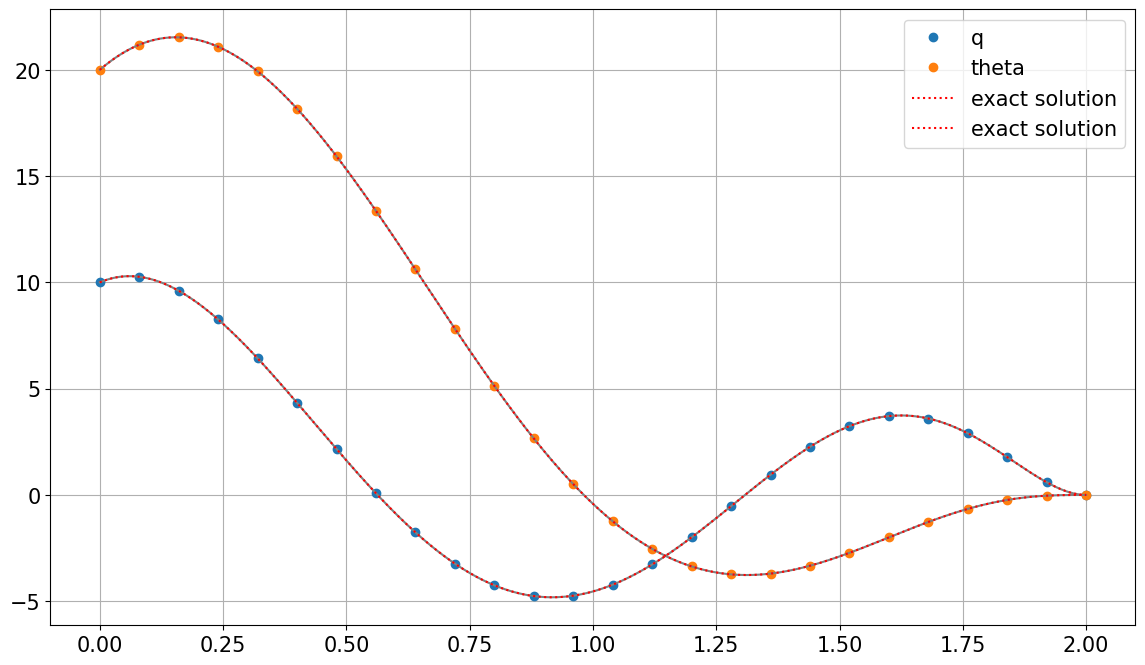

In [453]:
plt.figure(figsize=[14,8])
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],q_res[:,ii], 'o', label = labels[ii])
    plt.plot(t_interp, q_arr[:,ii], 'grey')
plt.plot(t_interp_ex, q_interp_ex, 'r:', label = 'exact solution')
plt.grid()
plt.legend()

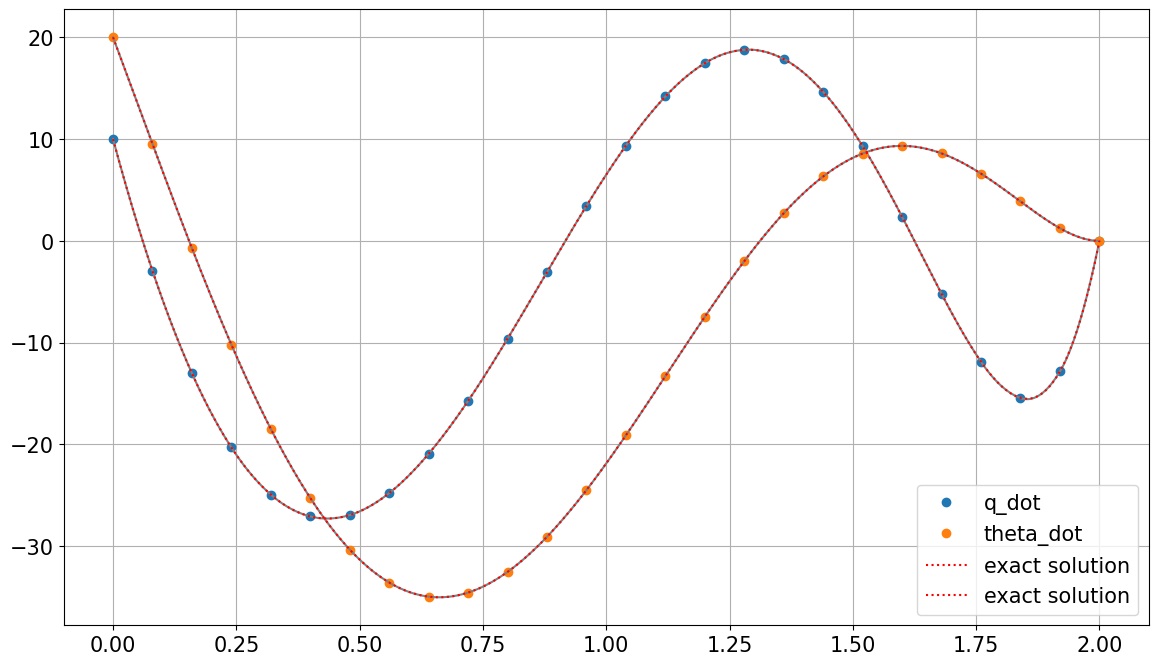

In [454]:
plt.figure(figsize=[14,8])
labels= ['q_dot', 'theta_dot']
for ii in range(2):
    plt.plot(_res['t'],v_res[:,ii], 'o', label = labels[ii])
    plt.plot(t_interp, v_arr[:,ii], 'grey')
plt.plot(t_interp_ex, v_interp_ex, 'r:', label = 'exact solution')
plt.grid()
plt.legend()

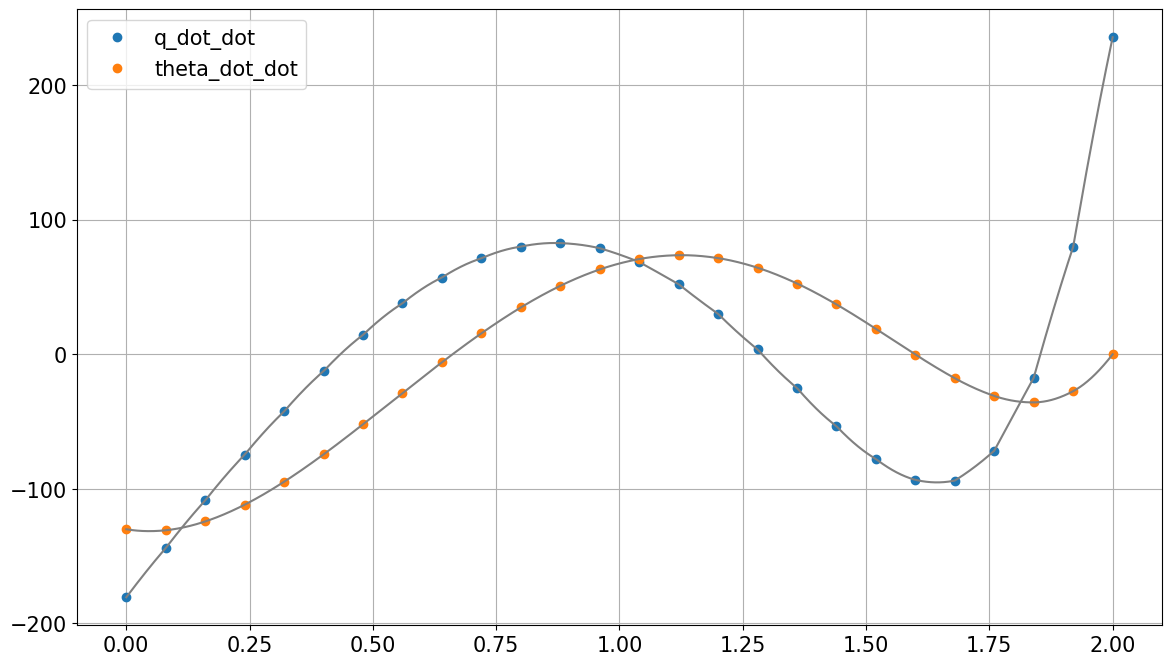

In [455]:
plt.figure(figsize=[14,8])
labels= ['q_dot_dot', 'theta_dot_dot']
for ii in range(2):
    plt.plot(_res['t'],a_res[:,ii], 'o', label = labels[ii])
    plt.plot(t_interp, a_arr[:,ii], 'grey')
plt.grid()
plt.legend()

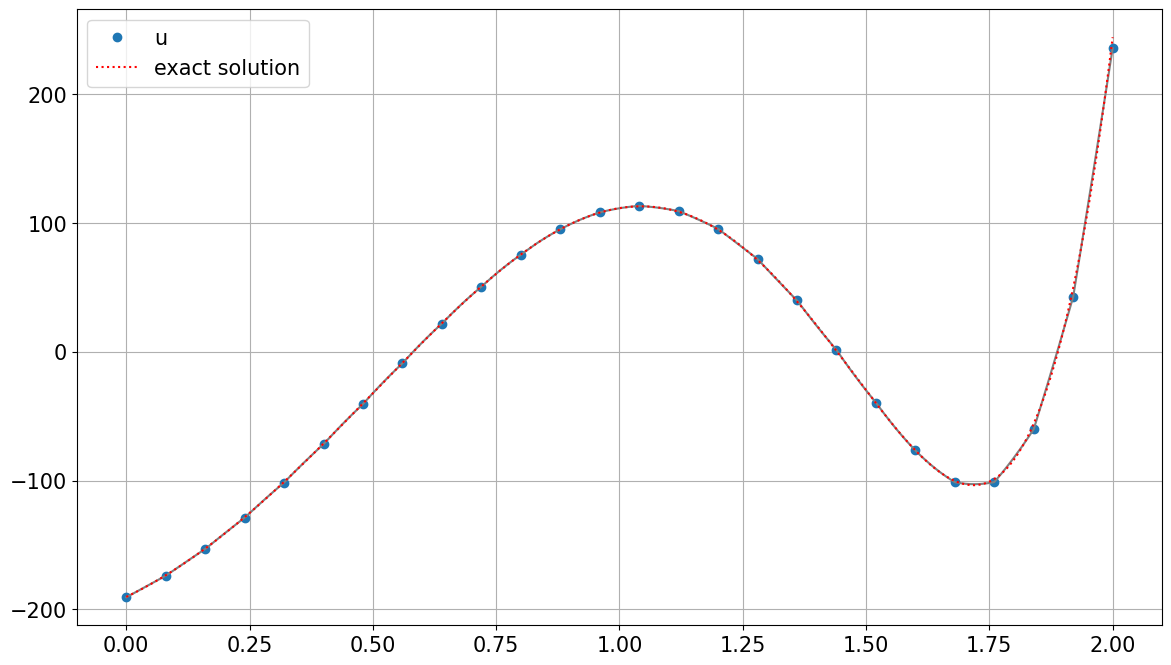

In [413]:
plt.figure(figsize=[14,8])
plt.plot(_res['t_col'],_res['u'][:], 'o', label = 'u')
plt.plot(t_interp, u_arr, 'grey')
plt.plot(t_interp_ex, u_interp_ex, 'r:', label = 'exact solution')
plt.grid()
plt.legend()

In [333]:
from chords.util import (sch_to_lab, sch_to_color, sch_to_long_label, scheme_kwargs, oct_fig_size, set_fonts)
set_fonts()

## Sistematic comparison of schemes for different values of N

Now let's solve the problem with different methods.

### Caution!

Executing the next cell may require some time!

In [416]:
schemes = ['hsn_parab', 'TD_LG', 'TD_CG','BU_LG', 'BU_CG', 'LG', 'CG'] #If you defined a custom function, name your scheme here
initials = ['lin']
solve_repetitions = 2 #Increase this number to get more reliable values of execution times
N_arr = [
    5, 7, 10, 12, 15, 20, 25,]# 30, 35, 40,]# 45, 50, 55, 60, 70, 80, 90, 100,
    #110, 120, 125, 130, 140, 150, 160, 170, 175, 180, 190, 200, 220, 225, 240, 250, 260, 275,
    #280, 300, 325, 350, 375, 400,]# 425, 450, 475, 500, 525, 550, 575, 600]# You can increase the numbers here, but it will take more time
#N_arr = [50, 60,]
results = {}

for scheme in schemes:
        for order in [1, 2, 4]:
            if scheme == 'LG2' and order != 2:
                continue
            if scheme in ['LG', 'LGL', 'LGR', 'CG', 'CGL', 'CGR'] and order != 1:
                continue
            key = scheme + f'_{order}'
            results[key] = {'N_arr':N_arr}
            results[key]['scheme'] = scheme
            results[key]['order'] = order
            
for N in N_arr:
    print(f'\tN = {N}')
    for scheme in schemes:
        for order in [1, 2, 4]:
            if scheme == 'LG2' and order != 2:
                continue
            if scheme in ['LG', 'LGL', 'LGR', 'CG', 'CGL', 'CGR'] and order != 1:
                continue
            if order == 4:
                function = casadi_damper_4
            else:
                function = casadi_damper_2
            key = scheme + f'_{order}'
            print(f'Problem: {key}, ', time.strftime('%H:%M:%S ', time.localtime(time.time())))
            try:
                results[key][N] = function(
                    scheme,
                    N, 
                    'lin',
                    solve_repetitions=solve_repetitions,
                    order = order,
                    silent=True, 
                    verbose=False)
            except: 
                results[key][N] = None
                print('ATTEMPT FAILED!!')
                results[key][N] = copy(function(
                    scheme,
                    20, 
                    'lin',
                    solve_repetitions=solve_repetitions,
                    order = 2,
                    silent=True, 
                    verbose=False))
                for item in results[key][N]:
                    try:
                        results[key][N][item] = results[key][N][item]*np.nan
                    except TypeError:
                        results[key][N][item] = np.nan
        


	N = 5
Problem: hsn_parab_1,  20:06:21 
Problem: hsn_parab_2,  20:06:21 
Problem: hsn_parab_4,  20:06:21 
Problem: TD_LG_1,  20:06:21 
Problem: TD_LG_2,  20:06:21 
Problem: TD_LG_4,  20:06:21 
Problem: TD_CG_1,  20:06:22 
Problem: TD_CG_2,  20:06:22 
Problem: TD_CG_4,  20:06:22 
Problem: BU_LG_1,  20:06:24 
Problem: BU_LG_2,  20:06:24 
Problem: BU_LG_4,  20:06:24 
Problem: BU_CG_1,  20:06:24 
Problem: BU_CG_2,  20:06:24 
Problem: BU_CG_4,  20:06:24 
Problem: LG_1,  20:06:25 
Problem: CG_1,  20:06:25 
	N = 7
Problem: hsn_parab_1,  20:06:25 
Problem: hsn_parab_2,  20:06:25 
Problem: hsn_parab_4,  20:06:25 
Problem: TD_LG_1,  20:06:25 
Problem: TD_LG_2,  20:06:25 
Problem: TD_LG_4,  20:06:25 
Problem: TD_CG_1,  20:06:27 
Problem: TD_CG_2,  20:06:27 
Problem: TD_CG_4,  20:06:27 
Problem: BU_LG_1,  20:06:28 
Problem: BU_LG_2,  20:06:28 
Problem: BU_LG_4,  20:06:28 
Problem: BU_CG_1,  20:06:29 
Problem: BU_CG_2,  20:06:29 
Problem: BU_CG_4,  20:06:29 
Problem: LG_1,  20:06:29 
Problem: CG_1,

In [417]:
for key in results.keys():
        _c = []
        _cpudt = []
        _iters = []
        for N in results[key]['N_arr']:
            _c.append(results[key][N]['cost'])
            _cpudt.append(results[key][N]['cpudt'])
            _iters.append(results[key][N]['iter_count'])
        results[key]['cost'] = np.array(_c)
        results[key]['cpudt'] = np.array(_cpudt)
        results[key]['iter_count'] = np.array(_iters)

#titles = ['LG','LG2']#'D2', 'LGL', 
schemes =['trapz', 'trapz_mod', 'hs_parab', 'hs_mod_parab',]
plt.figure(figsize=oct_fig_size)
for ii in range(len(schemes)):
    key = schemes[ii]
    plt.plot(
        results[key]['N_arr'],
        results[key][f'cpudt'],
        **scheme_kwargs(key, longlabel=False)
    )
plt.grid()
plt.legend()
#plt.yscale('log')
plt.title('Cart-pole: Optimization time')
plt.xlabel('Number of intervals')
plt.ylabel('Time (s)')
plt.tight_layout(pad = 0.0)
#plt.savefig('2d_order/5_link_optimization_vs_interval_number.pdf', format='pdf')

Text(0.5, 1.0, 'Final traj cost')

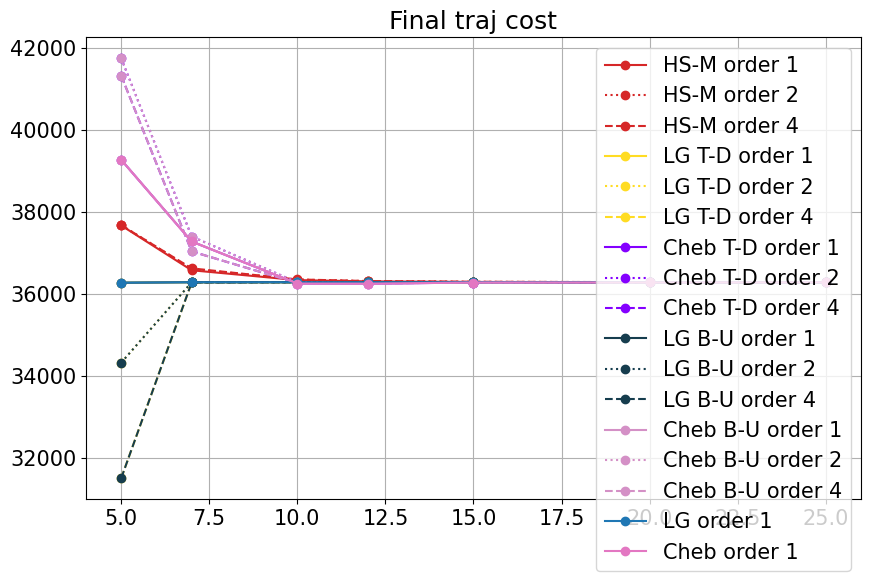

In [419]:
plt.figure(figsize=oct_fig_size)
for key in results.keys():
    scheme = results[key]['scheme']
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    if results[key]['order'] == 1:
        plot_kw['ls'] = '-'  
    elif results[key]['order'] == 2:
        plot_kw['ls'] = ':'
    else:
        plot_kw['ls'] = '--'
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    plt.plot(results[key]['N_arr'], results[key]['cost'][:], **plot_kw)
#plt.yscale('log')
plt.grid()
plt.legend()
plt.title('Final traj cost')

N = 60
scheme = 'BU_LG'
plt.figure(figsize=[14,8])

for ii in range(1,3):
    key = scheme + f'_{ii}'
    uu_pol, q_n_der_pols = chords.bu_pseudospectral.Polynomial_interpolations_BU(
        results[key][N]['x_d'],
        results[key][N]['x'][0,:],
        results[key][N]['u'],
        scheme,
        ii,
        0,
        2,
        N
    )
    

    plt.plot(results[key][N]['t_col'],results[key][N]['u'][:], 'o', label = 'u ' + key)
    plt.plot(t_interp_arr, uu_pol(t_interp_arr), 'grey',':')
plt.grid()
plt.legend()
points_ii = np.array([0, 12, 27, 33, 59])
uu_in = results[key][N]['u'][points_ii]
tt_in = results[key][N]['t_col'][points_ii]
plt.plot(tt_in,uu_in, '-', label = 'u interp')

## Interpolations

In [464]:
n_interp = 2000
n_q = 2
for key in results.keys():
    scheme = results[key]['scheme'] 
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    order = results[key]['order']
    for N in N_arr:
        print(f'\tN = {N}')
        res = results[key][N]
        if res['scheme'] is np.nan:
            print('\t\tNaN in Scheme')
            interpolations = copy(interpolation(
                    results[key][20],
                    problem_order=2,
                    scheme_order=2,
                    x_interp=None,
                    u_interp=None,
                    n_interp=n_interp,
                    save_in_res = False
                ))
            for item in interpolations:
                try:
                    interpolations[item] = interpolations[item]*np.nan
                except TypeError:
                    interpolations[item] = np.nan
        else:
            interpolations = interpolation(
                    res,
                    problem_order=2,
                    scheme_order=2,
                    x_interp=None,
                    u_interp=None,
                    n_interp=n_interp,
                    save_in_res = False
                )
            if order == 4:
                interpolations = interp_dict_Y_to_X(interpolations)
        res['interpolations'] = interpolations
            

Problem: hsn_parab_1
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: hsn_parab_2
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: hsn_parab_4
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: TD_LG_1
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: TD_LG_2
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: TD_LG_4
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: TD_CG_1
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: TD_CG_2
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: TD_CG_4
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: BU_LG_1
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: BU_LG_2
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: BU_LG_4
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: BU_CG_1
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: BU_CG_2
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N

## Dynamic Error

Now we can compute the dynamic errors for each case

In [465]:
def total_state_error(t_arr, dyn_err):
    errors = np.trapz(np.abs(dyn_err), t_arr, axis=0)
    return errors

In [466]:
import chords
import importlib
importlib.reload(chords.util)
importlib.reload(chords.analysis)
importlib.reload(chords)
from chords.util import sch_to_color, sch_to_lab

In [467]:
from chords.analysis import dynamic_errors, dynamic_errors_from_interp

In [468]:
n_interp = 2000
n_q = 2
for key in results.keys():
    scheme = results[key]['scheme'] 
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        res = results[key][N]
        if res['scheme'] is np.nan:
            print('\t\tNaN in Scheme')
            nan_arr = np.zeros([n_interp, n_q])*np.nan
            errors= {
                'compat_err_1_interp': nan_arr,
                'dyn_err_interp' : nan_arr,
            }
        else:
            errors = dynamic_errors_from_interp(
                res['interpolations'],
                F_num,
                params,
                dynamics_error_mode="q",
                problem_order=2
            )
        res['error'] = errors
        dyn_err_q = errors['compat_err_1_interp']
        dyn_err_2 = errors['dyn_err_interp']
        t_arr = np.linspace(0,2, n_interp)
        tot_dyn_err_q = total_state_error(t_arr, dyn_err_q)
        tot_dyn_err_2 = total_state_error(t_arr, dyn_err_2)
        errors['err_q'] = tot_dyn_err_q
        errors['err_2'] = tot_dyn_err_2
            

Problem: hsn_parab_1
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: hsn_parab_2
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: hsn_parab_4
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: TD_LG_1
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: TD_LG_2
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: TD_LG_4
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: TD_CG_1
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: TD_CG_2
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: TD_CG_4
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: BU_LG_1
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: BU_LG_2
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: BU_LG_4
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: BU_CG_1
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N = 25
Problem: BU_CG_2
	N = 5
	N = 7
	N = 10
	N = 12
	N = 15
	N = 20
	N

In [469]:
def arr_mod(x):
    x_1 = np.sum(x*x, axis=1)
    return np.sqrt(x_1)
def arr_sum(x):
    return np.sum(np.abs(x), axis = 1)
def arr_max(x):
    return np.max(np.abs(x), axis = 1)

In [470]:
for key in results.keys():
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    err_q_acum = []
    err_2_acum = []
    cpudt = []
    for N in N_arr:
        errors = results[key][N]['error']
        err_q_acum.append(np.sum(errors['err_q']))
        err_2_acum.append(np.sum(errors['err_2']))
    results[key]['err_q_acum'] = np.array(err_q_acum, dtype = float)
    results[key]['err_2_acum'] = np.array(err_2_acum, dtype = float)
    

Problem: hsn_parab_1
Problem: hsn_parab_2
Problem: hsn_parab_4
Problem: TD_LG_1
Problem: TD_LG_2
Problem: TD_LG_4
Problem: TD_CG_1
Problem: TD_CG_2
Problem: TD_CG_4
Problem: BU_LG_1
Problem: BU_LG_2
Problem: BU_LG_4
Problem: BU_CG_1
Problem: BU_CG_2
Problem: BU_CG_4
Problem: LG_1
Problem: CG_1


def plot_by_segments(results, schemes, N, thing_to_plot, title, ylabel, component = 'all'):
    plt.figure(figsize=oct_fig_size)
    plot_coll_p = False
    for scheme in schemes:
        t_arr = np.linspace(0,
                        results[scheme][N]['t'][-1],
                        results[scheme][N][thing_to_plot].shape[0])
        interv_n = (N * t_arr)/results[scheme][N]['t'][-1]
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            y_plot = results[scheme][N][thing_to_plot]
            if component != 'all':
                y_plot = y_plot[:, component]
            plt.plot(
                t_arr[cut_p:jj],
                y_plot[cut_p:jj],
                '-', c = sch_to_color(scheme),
                label = sch_to_lab(scheme) if cut_p == 0 else None)
            cut_p = jj
        if 'hs' in scheme:
            plot_coll_p = True
    plt.plot(results[scheme][N]['t'], np.zeros(N+1), 'ok', ms=5, label = 'knot & collocation points')
    if plot_coll_p:
        plt.plot(results[scheme][N]['t_c'], 
                     np.zeros(N), 'ow', ms=5, markeredgecolor='k',
                     label = 'collocation points')
    plt.legend()
    plt.grid()
    #plt.ylim([-0.01,y_max_list[ii]])
    plt.title(title)
    plt.xlabel('Time(s)')
    plt.ylabel(ylabel)
    plt.tight_layout(pad = 0.0)
    #plt.yscale('log')
    #plt.savefig(f'2d_order/5_link_HS_N{N}_second_order_dynamic_error.pdf', format='pdf')

In [471]:
from chords.util import plot_by_segments

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_q_int'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        plt.title(r'First order dynamic error $\varepsilon^{[1]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_First_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

In [472]:
results[key][N].keys()

dict_keys(['cpudt', 'iter_count', 'cost', 'opti_stats', 'scheme_mode', 'n_q', 'n_u', 'solve_order', 'params', 'n_coll', 'scheme', 'x', 'x_node', 'x_like_u', 'x_d', 'x_d_node', 'x_d_like_u', 'u', 't', 't_node', 't_col', 'tau', 'tau_node', 'tau_col', 'lam', 'u_like_x', 'q', 'q_node', 'q_like_u', 'v', 'v_node', 'v_like_u', 'interpolations', 'error'])

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_2_int'][cut_p:jj,ii], '-', c = sch_to_color(key), label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'Second order dynamic error $\varepsilon^{[2]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s^2' if ii == 0 else'rad/s^2'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

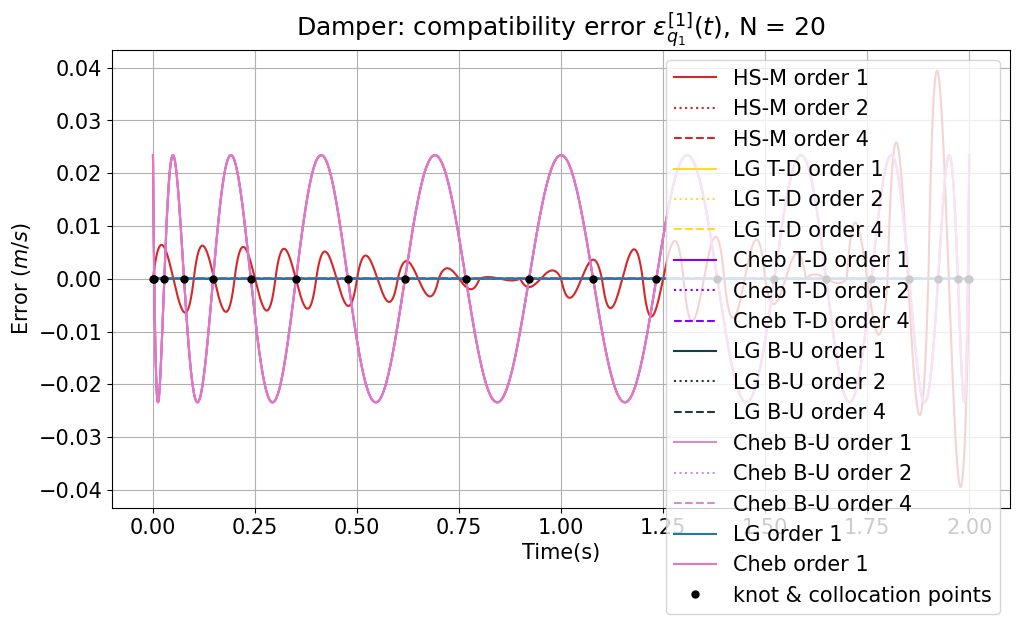

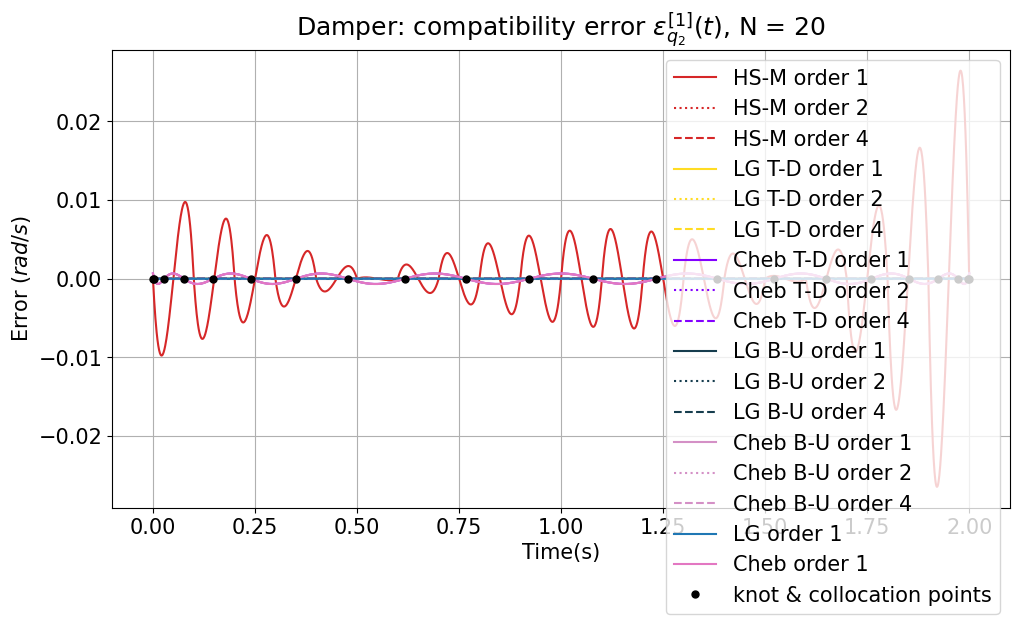

In [473]:
#schemes = ['trapz', 'trapz_mod']
ylabels = ['Error $(m/s)$','Error $(rad/s)$']
N = 20

for component in range(2):
    plt.figure(figsize=oct_fig_size)
    t_arr = np.linspace(
            0, results[key][N]["t"][-1], results[key][N]['error']['compat_err_1_interp'].shape[0]
        )
    for key in results.keys():
        scheme = results[key]['scheme']
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        if results[key]['order'] == 1:
            plot_kw['ls'] = '-'  
        elif results[key]['order'] == 2:
            plot_kw['ls'] = ':'
        else:
            plot_kw['ls'] = '--'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        plot_kw['marker'] = ''
        plt.plot(t_arr, results[key][N]['error']['compat_err_1_interp'][:,component], **plot_kw)
    plt.plot(
        results[key][N]["t"],
        np.zeros(len(results[key][N]["t"])),
        "ok",
        ms=5,
        label="knot & collocation points",
    )
    plt.legend()
    plt.grid()
    plt.title(r'Damper: compatibility error $\varepsilon^{[1]}_{q_'+f'{component+1}}}(t)$, N = {N}')
    plt.xlabel("Time(s)")
    plt.ylabel(ylabels[component])
    plt.tight_layout(pad=0.0)
    #plt.savefig(f'2d_order/Cartpole_First_Order_Dynamic_Error_q_{component+1}_TZ_schemes_N_{N}.eps', format='eps')

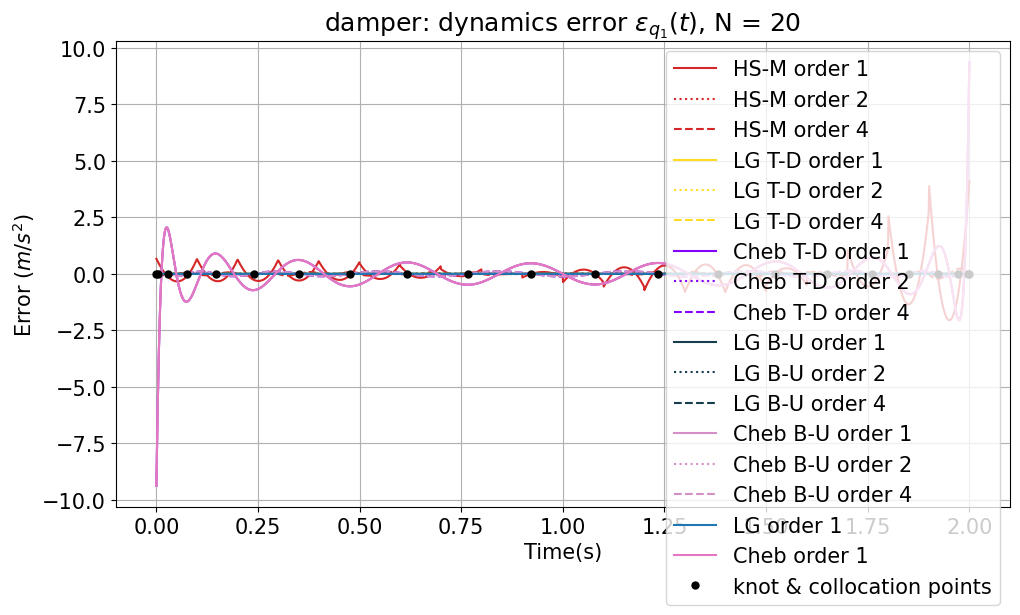

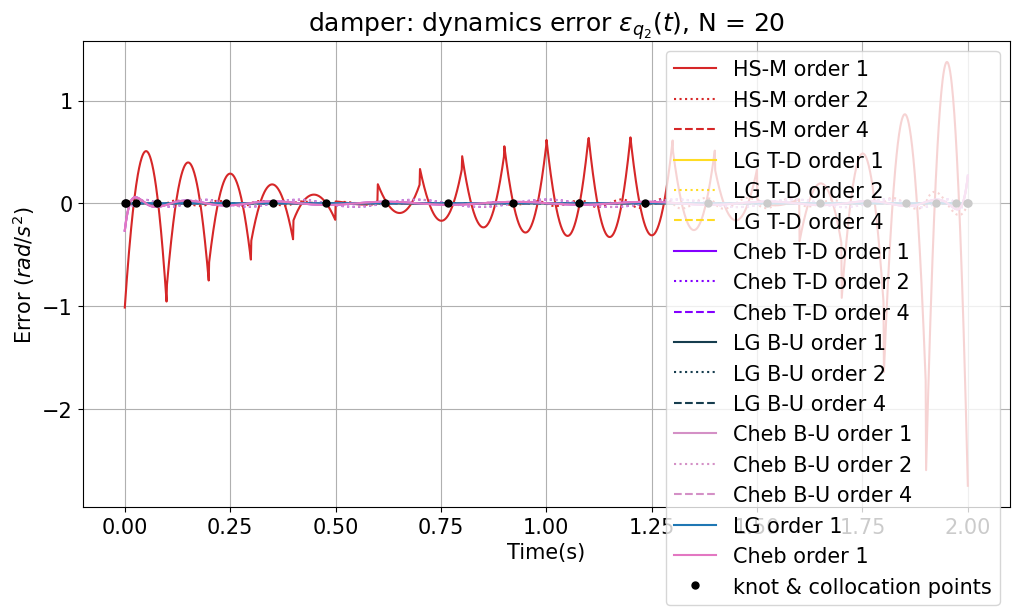

In [474]:
ylabels = ['Error $(m/s^2)$','Error $(rad/s^2)$']
N = 20
for component in range(2):
    plt.figure(figsize=oct_fig_size)
    t_arr = np.linspace(
            0, results[key][N]["t"][-1], results[key][N]['error']['dyn_err_interp'].shape[0]
        )
    for key in results.keys():
        scheme = results[key]['scheme']
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        if results[key]['order'] == 1:
            plot_kw['ls'] = '-'  
        elif results[key]['order'] == 2:
            plot_kw['ls'] = ':'
        else:
            plot_kw['ls'] = '--'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        plot_kw['marker'] = ''
        plt.plot(t_arr, results[key][N]['error']["dyn_err_interp"][:,component], **plot_kw)
    plt.plot(
        results[key][N]["t"],
        np.zeros(len(results[key][N]["t"])),
        "ok",
        ms=5,
        label="knot & collocation points",
    )
    plt.legend()
    plt.grid()
    plt.title(r'damper: dynamics error $\varepsilon_{q_'+f'{component+1}}}(t)$, N = {N}')
    plt.xlabel("Time(s)")
    plt.ylabel(ylabels[component])
    plt.tight_layout(pad=0.0)
    #plt.savefig(f'2d_order/Cartpole_Second_Order_Dynamic_Error_q_{component+1}_HS_schemes_N_{N}.eps', format='eps')

### Error respect to exact solution

In [437]:
def x_points_error(x_arr, t_arr):
    x_exact = exact_solution_array(t_arr)
    return x_exact - x_arr

def x_points_error_mean(x_arr, t_arr):
    x_err = x_points_error(x_arr, t_arr)
    n_x = x_arr.shape[1]
    order =2
    n_q = n_x//order
    q_err = x_err[:, :n_q]
    v_err = x_err[:, n_q:]
    return np.mean(np.abs(q_err)), np.mean(np.abs(v_err))

def x_interp_error(x_interp):
    n_t = x_interp.shape[0]
    x_exact = exact_solution_equispaced(n_t)
    return x_exact - x_interp

def x_interp_error_integ(x_interp):
    n_t = x_interp.shape[0]
    n_x = x_interp.shape[1]
    order = 2
    n_q =n_x // order
    t_end = 2
    t_arr = np.linspace(0, t_end, n_t)
    x_err = x_interp_error(x_interp)
    x_err_int = np.trapz(np.abs(x_err), t_arr, axis=0)
    return np.sum(x_err_int[:n_q]), np.sum(x_err_int[n_q:])

In [438]:
n_interp = 2000
n_q = 2
for key in results.keys():
    scheme = results[key]['scheme'] 
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    order = results[key]['order']
    for N in N_arr:
    #    print(f'\tN = {N}')
        res = results[key][N]
        if res['scheme'] is np.nan:
            print('\t\tNaN in Scheme')
            res['error']['exact_err_q_mean']= np.nan
            res['error']['exact_err_v_mean']= np.nan
            res['error']['exact_err_q_interp']= np.nan
            res['error']['exact_err_v_interp']= np.nan
        else:
            res_x = res['x']
            if order == 4:
                res_x = Y_to_X(res_x)
            q_err_mean, v_err_mean = x_points_error_mean(
                x_arr = res_x,
                t_arr = res['t'])
            res['error']['exact_err_q_mean']= q_err_mean
            res['error']['exact_err_v_mean']= q_err_mean
            q_err_interp, v_err_interp = x_interp_error_integ(
                x_interp = res['interpolations']['x'])
            
            res['error']['exact_err_q_interp']= q_err_interp
            res['error']['exact_err_v_interp']= v_err_interp
            
            

Problem: hsn_parab_1
Problem: hsn_parab_2
Problem: hsn_parab_4
Problem: TD_LG_1
Problem: TD_LG_2
Problem: TD_LG_4
Problem: TD_CG_1
Problem: TD_CG_2
Problem: TD_CG_4
Problem: BU_LG_1
Problem: BU_LG_2
Problem: BU_LG_4
Problem: BU_CG_1
Problem: BU_CG_2
Problem: BU_CG_4
Problem: LG_1
Problem: CG_1


In [439]:
for key in results.keys():
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    err_q_ex_acum = []
    err_v_ex_acum = []
    err_q_interp_ex_acum = []
    err_v_interp_ex_acum = []
    cpudt = []
    for N in N_arr:
        errors = results[key][N]['error']
        err_q_ex_acum.append(errors['exact_err_q_mean'])
        err_v_ex_acum.append(errors['exact_err_v_mean'])
        err_q_interp_ex_acum.append(errors['exact_err_q_interp'])
        err_v_interp_ex_acum.append(errors['exact_err_v_interp'])
    results[key]['exact_err_q_mean_acum'] = np.array(err_q_ex_acum, dtype = float)
    results[key]['exact_err_v_mean_acum'] = np.array(err_v_ex_acum, dtype = float)
    results[key]['exact_err_q_interp_acum'] = np.array(err_q_interp_ex_acum, dtype = float)
    results[key]['exact_err_v_interp_acum'] = np.array(err_v_interp_ex_acum, dtype = float)
    

Problem: hsn_parab_1
Problem: hsn_parab_2
Problem: hsn_parab_4
Problem: TD_LG_1
Problem: TD_LG_2
Problem: TD_LG_4
Problem: TD_CG_1
Problem: TD_CG_2
Problem: TD_CG_4
Problem: BU_LG_1
Problem: BU_LG_2
Problem: BU_LG_4
Problem: BU_CG_1
Problem: BU_CG_2
Problem: BU_CG_4
Problem: LG_1
Problem: CG_1


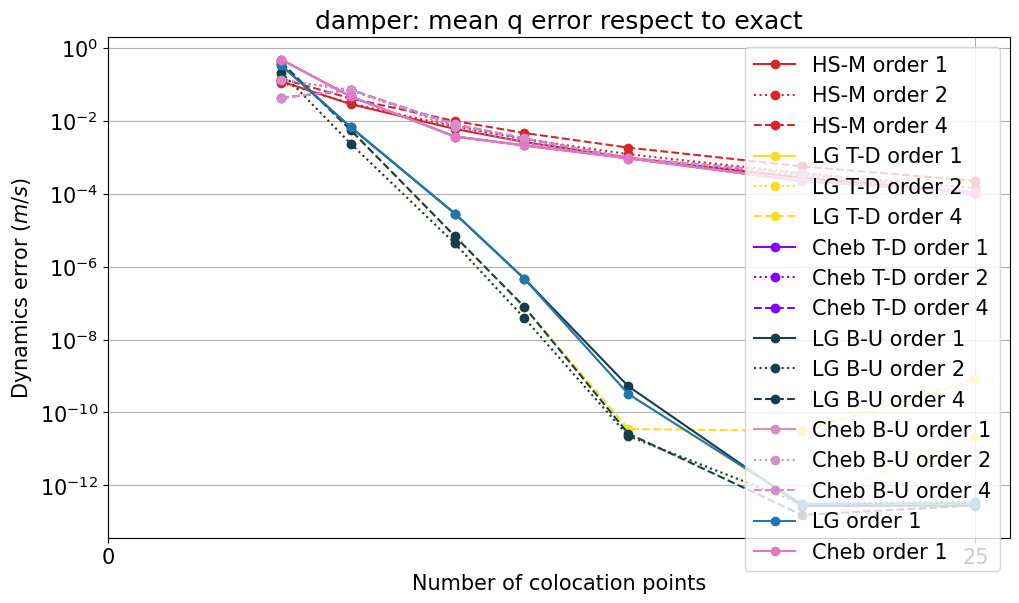

In [445]:

schemes = [
    #'LG2_2',
    'hsn_parab_1',
    'hsn_parab_2',
    'hsn_parab_4',
    'TD_LG_1',
    'TD_LG_2',
    'TD_LG_4',
    'TD_CG_1',
    'TD_CG_2',
    'TD_CG_4',
    'BU_LG_1',
    'BU_LG_2',
    'BU_LG_4',
    'BU_CG_1',
    'BU_CG_2',
    'BU_CG_4',
    'LG_1',
    'CG_1',
    #'LGR_1',
    #'BU_LGR_1',
    #'BU_LGR_2',
    #'LGL_1',
    #'BU_LGL_1',
    #'BU_LGL_2'
]

data_key = 'exact_err_q_mean_acum'
for qq in range(1):
    plt.figure(figsize=oct_fig_size)
    plt.title(r'damper: mean q error respect to exact')#_{q_'+f'{qq+1}}}
    for key in schemes: #results.keys():#
        scheme = results[key]['scheme']
        #if "C" in scheme:
            #continue
            #pass
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        if results[key]['order'] == 1:
            plot_kw['ls'] = '-'  
        elif results[key]['order'] == 2:
            plot_kw['ls'] = ':'
        else:
            plot_kw['ls'] = '--'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        N_arr = results[key]['N_arr']
        if len(results[key][data_key].shape) == 1:
            plt.plot(N_arr,
             results[key][data_key],
             **plot_kw)
        else:
            plt.plot(N_arr,
             results[key][data_key][:,qq],
             **plot_kw)
    plt.yscale('log')
    #ticks = np.array(results[key]['N_arr'])
    ticks = np.arange(0, results[key]['N_arr'][-1]+1, 25)
    plt.xticks(ticks, labels=ticks)
    plt.xlabel('Number of colocation points')
    plt.grid()
    plt.legend()#loc = 'lower left'
    units = 'm/s' if qq == 0 else'rad/s'
    plt.ylabel(f'Dynamics error $({units})$')
    plt.tight_layout(pad = 0.0)
    # If you are running the notebook locally and want to save the plots,
    # uncomment the next line
    #plt.savefig(f'BU_pseudo/Cartpole_BU_pseudosp_Gauss_Dynamic_Error_q_{qq+1}_vs_N.eps', format='eps')

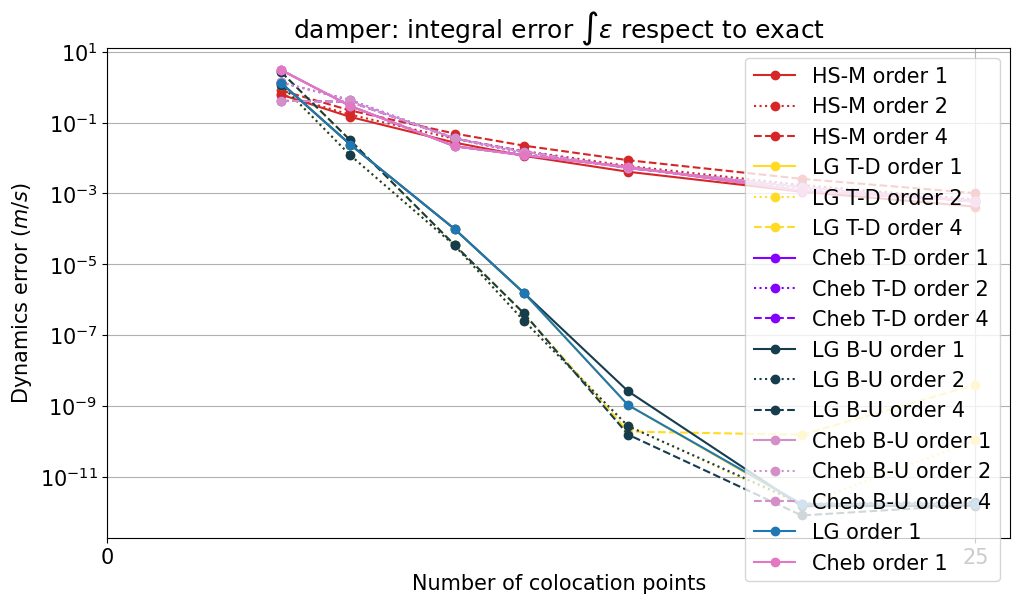

In [446]:

schemes = [
    #'LG2_2',
    'hsn_parab_1',
    'hsn_parab_2',
    'hsn_parab_4',
    'TD_LG_1',
    'TD_LG_2',
    'TD_LG_4',
    'TD_CG_1',
    'TD_CG_2',
    'TD_CG_4',
    'BU_LG_1',
    'BU_LG_2',
    'BU_LG_4',
    'BU_CG_1',
    'BU_CG_2',
    'BU_CG_4',
    'LG_1',
    'CG_1',
    #'LGR_1',
    #'BU_LGR_1',
    #'BU_LGR_2',
    #'LGL_1',
    #'BU_LGL_1',
    #'BU_LGL_2'
]

data_key = 'exact_err_q_interp_acum'
for qq in range(1):
    plt.figure(figsize=oct_fig_size)
    plt.title(r'damper: integral error $\int\varepsilon$ respect to exact')#_{q_'+f'{qq+1}}}
    for key in schemes: #results.keys():#
        scheme = results[key]['scheme']
        #if "C" in scheme:
            #continue
            #pass
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        if results[key]['order'] == 1:
            plot_kw['ls'] = '-'  
        elif results[key]['order'] == 2:
            plot_kw['ls'] = ':'
        else:
            plot_kw['ls'] = '--'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        N_arr = results[key]['N_arr']
        if len(results[key][data_key].shape) == 1:
            plt.plot(N_arr,
             results[key][data_key],
             **plot_kw)
        else:
            plt.plot(N_arr,
             results[key][data_key][:,qq],
             **plot_kw)
    plt.yscale('log')
    #ticks = np.array(results[key]['N_arr'])
    ticks = np.arange(0, results[key]['N_arr'][-1]+1, 25)
    plt.xticks(ticks, labels=ticks)
    plt.xlabel('Number of colocation points')
    plt.grid()
    plt.legend()#loc = 'lower left'
    units = 'm/s' if qq == 0 else'rad/s'
    plt.ylabel(f'Dynamics error $({units})$')
    plt.tight_layout(pad = 0.0)
    # If you are running the notebook locally and want to save the plots,
    # uncomment the next line
    #plt.savefig(f'BU_pseudo/Cartpole_BU_pseudosp_Gauss_Dynamic_Error_q_{qq+1}_vs_N.eps', format='eps')

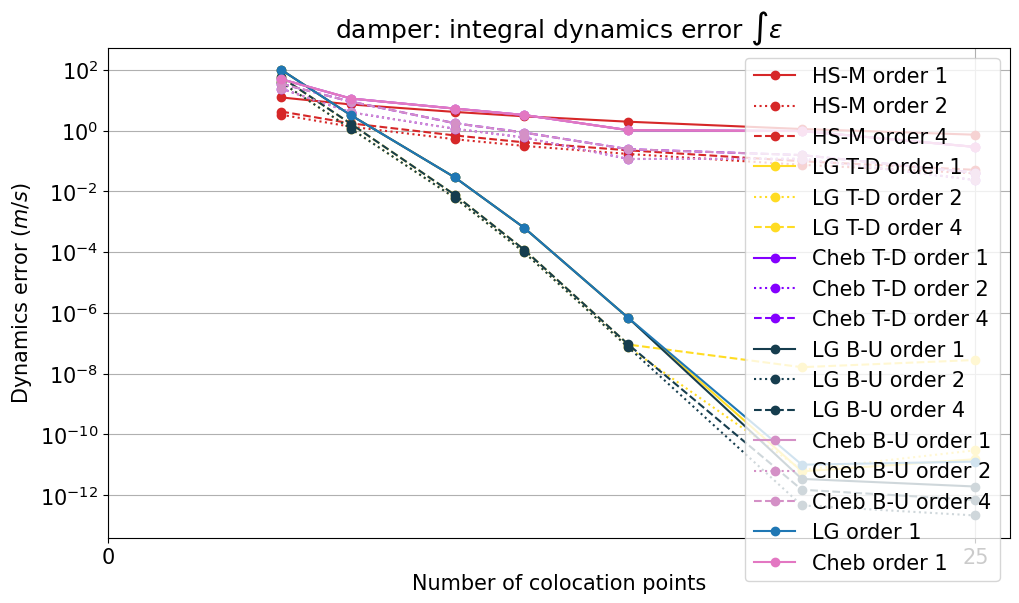

In [475]:
data_array = ['err_q_acum','err_v_acum','err_2_acum','cpudt']
schemes = [
    #'LG2_2',
    'hsn_parab_1',
    'hsn_parab_2',
    'hsn_parab_4',
    'TD_LG_1',
    'TD_LG_2',
    'TD_LG_4',
    'TD_CG_1',
    'TD_CG_2',
    'TD_CG_4',
    'BU_LG_1',
    'BU_LG_2',
    'BU_LG_4',
    'BU_CG_1',
    'BU_CG_2',
    'BU_CG_4',
    'LG_1',
    'CG_1',
    #'LGR_1',
    #'BU_LGR_1',
    #'BU_LGR_2',
    #'LGL_1',
    #'BU_LGL_1',
    #'BU_LGL_2'
]

data_key = data_array[2]
for qq in range(1):
    plt.figure(figsize=oct_fig_size)
    plt.title(r'damper: integral dynamics error $\int\varepsilon$')#_{q_'+f'{qq+1}}}
    for key in schemes: #results.keys():#
        scheme = results[key]['scheme']
        #if "C" in scheme:
            #continue
            #pass
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        if results[key]['order'] == 1:
            plot_kw['ls'] = '-'  
        elif results[key]['order'] == 2:
            plot_kw['ls'] = ':'
        else:
            plot_kw['ls'] = '--'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        N_arr = results[key]['N_arr']
        if len(results[key][data_key].shape) == 1:
            plt.plot(N_arr,
             results[key][data_key],
             **plot_kw)
        else:
            plt.plot(N_arr,
             results[key][data_key][:,qq],
             **plot_kw)
    plt.yscale('log')
    #ticks = np.array(results[key]['N_arr'])
    ticks = np.arange(0, results[key]['N_arr'][-1]+1, 25)
    plt.xticks(ticks, labels=ticks)
    plt.xlabel('Number of colocation points')
    plt.grid()
    plt.legend()#loc = 'lower left'
    units = 'm/s' if qq == 0 else'rad/s'
    plt.ylabel(f'Dynamics error $({units})$')
    plt.tight_layout(pad = 0.0)
    # If you are running the notebook locally and want to save the plots,
    # uncomment the next line
    #plt.savefig(f'BU_pseudo/Cartpole_BU_pseudosp_Gauss_Dynamic_Error_q_{qq+1}_vs_N.eps', format='eps')

In [443]:
results[key]['N_arr'][:6]+results[key]['N_arr'][6::2]

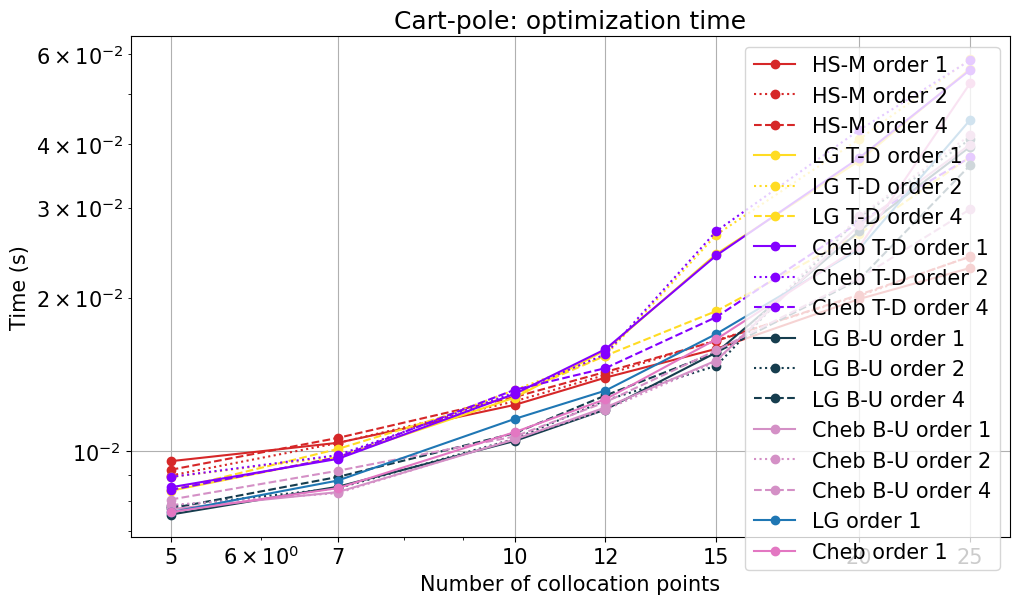

In [448]:

plt.figure(figsize=[10,6])
for key in results.keys():
    scheme = results[key]['scheme']
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    if results[key]['order'] == 1:
        plot_kw['ls'] = '-'  
    elif results[key]['order'] == 2:
        plot_kw['ls'] = ':'
    else:
        plot_kw['ls'] = '--'
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    plt.plot(results[key]['N_arr'],
             results[key][f'cpudt'],
             **plot_kw)
plt.grid()
plt.legend()
plt.title('Cart-pole: optimization time')
plt.xlabel('Number of collocation points')
plt.ylabel('Time (s)')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout(pad = 0.0)
#ticks = np.array(results[key]['N_arr'])
ticks = np.array(results[key]['N_arr'][:6]+results[key]['N_arr'][6:20:1])#+[150,200,300,400])
#ticks = np.arange(0, results[key]['N_arr'][-1]+1, 25)
plt.xticks(ticks, labels=ticks)
_ = []
# If you are running the notebook locally and want to save the plots,
# uncomment the next line
#plt.savefig(f'2d_order/Cartpole_optimization_time_vs_interval_number.eps', format='eps')

# Here we print the data shown in Table II of the paper
for scheme in ['trapz', 'trapz_mod', 'hs_parab', 'hs_mod_parab']:
    key = scheme 
    #for N in [25,50]:#results[key]['N_arr']:
    N = 25 if 'hs' in scheme else 50
    print('scheme:', scheme, 'N:', N,'\n\ttime:', results[key][N][f'cpudt'],
              '\n\tErr 1:', results[key][N]['err_q'], '\n\tErr 2:', results[key][N]['err_2'])

## Animation

from matplotlib import animation, rc
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 200

def create_anim(X, U, params):
    [g_n, l_n, m0_n, m1_n] = params
    
    N = X.shape[0]
    fig, ax = plt.subplots()
    y_scale = 1
    min_x_cart = np.min(X[:,0])
    max_x_cart = np.max(X[:,0])
    cart_displ = max_x_cart-min_x_cart
    size_x = 2*y_scale + cart_displ
    size_y = 2*y_scale
    draw_width = 14
    draw_height = draw_width / size_x * size_y
    
    x_0 = X[:,0]
    y_0 = np.zeros_like(x_0)
    x_1 = x_0 + l_n*np.sin(X[:,1])
    y_1 = y_0 - l_n*np.cos(X[:,1])
    
    x_cm = (m0_n * x_0 + m1_n * x_1)/(m0_n + m1_n)
    y_cm = (m0_n * y_0 + m1_n * y_1)/(m0_n + m1_n)

    fig.set_dpi(72)
    fig.set_size_inches([draw_width,draw_height])
    ax.set_xlim(( min_x_cart-y_scale, max_x_cart+y_scale))
    ax.set_ylim(( -y_scale, y_scale))

    #circle1 = plt.Circle((0, 0), l_n, color='b', ls = ":", fill=False)
    #ax.add_artist(circle1)
    ax.plot([min_x_cart - l_n, max_x_cart + l_n], [0,0], 'k', lw=1, ls = ':')

    line1, = ax.plot([], [], lw=2)
    line3, = ax.plot([], [], 'k', lw=1, ls = ':')
    #line_cm, = ax.plot([], [], 'g', lw=1, ls = ':')
    point0, = ax.plot([], [], marker='s', markersize=10, color="k")
    point1, = ax.plot([], [], marker='o', markersize=7, color="red")
    #point_cm, = ax.plot([], [], marker='o', markersize=10, color="green")
    u_max = max(np.max(np.abs(U[:])),1e-15)
    arrow_w = 0.1*l_n
    arrow_l = 0.7*l_n
    u_arrow = patches.Arrow(0, 0, 0, -arrow_l, color = 'gray',width = arrow_w)
    ax.add_patch(u_arrow)
    
    print_vars = [X[:,0], X[:,1], U[:], np.linspace(0, N-1, N, dtype=int)]
    print_var_names = ['q_0', 'q_1', 'u_0', 'step']
    texts = []
    ii = 0.8
    for arr in print_vars:
        texts.append(ax.text(-0.8, ii, "", fontsize = 12))
        ii -= 0.2*l_n
        
    xx_interpolated, uu_interpolated = interpolated_array(
        X,
        U,
        F = F_nump,
        h = 2/(N-1),
        t_array = np.linspace(0, 2, 5*(N-1)+1),
        params = params,
        scheme = 'hs_mod_parab',
        u_scheme = 'parab',
        scheme_params = {'u_c' : results['hs_mod_parab_lin'][N-1]['u_c']}
    )
    x_0_interp = xx_interpolated[:,0]
    y_0_interp = np.zeros_like(x_0_interp)
    x_1_interp = x_0_interp + l_n*np.sin(xx_interpolated[:,1])
    y_1_interp = y_0_interp - l_n*np.cos(xx_interpolated[:,1])
    
    def init():
        line1.set_data([], [])
        line3.set_data([], [])
        #line_cm.set_data([], [])
        point1.set_data([], [])
        #circle1.center = (0, 0)
        return (line1,)
    def animate(i):
        #circle1.center = (x_0[i], y_0[i])
        point0.set_data(x_0[i], y_0[i])
        line1.set_data([x_0[i], x_1[i]], [y_0[i], y_1[i]])    
        point1.set_data(x_1[i], y_1[i])
        #point_cm.set_data(x_cm[i], y_cm[i])
        line3.set_data(x_1_interp[:5*i+1], y_1_interp[:5*i+1])
        #line_cm.set_data(x_cm[:i], y_cm[:i])
        trans = Affine2D()
        u_arrow._patch_transform = trans.scale(U[i] * arrow_l / u_max, arrow_w).translate(x_0[i],0)
        for ii in range(len(texts)):
            text = texts[ii]
            name = print_var_names[ii]
            arr = print_vars[ii]
            if name == 'step':
                text.set_text("$step$ = " + str(arr[i]))
            else:
                text.set_text("$" + name + "$ = %.3f" % arr[i])
        return (line1,u_arrow)
    frame_indices = np.concatenate((np.zeros(10, dtype=int), np.arange(0, N, 1), np.ones(15, dtype=int)*(N-1)))
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frame_indices, interval=20, 
                               blit=True)
    return anim

anim = create_anim(results['hs_parab_lin'][25]['x'], results['hs_parab_lin'][25]['u'], params)

HTML(anim.to_jshtml())

f = r"cartpole_animation.mp4" 
writervideo = animation.FFMpegWriter(fps=12) 
# If you are running the notebook locally and want to save the animation,
# uncomment the next line
#anim.save(f, writer=writervideo)